In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from bs4 import BeautifulSoup
import requests

In [2]:
# scrape list of NBA teams from Wikipedia

teams = []

r = requests.get("https://en.wikipedia.org/wiki/National_Hockey_League")
text = r.text
soup = BeautifulSoup(text, 'html.parser')
rows = soup.find("table", attrs={"class": "wikitable"}).find_all("td")
for row in rows:
    elements = row.find_all("b")
    for el in elements:
        teams.append(el.text)
        
print len(teams)

30


In [3]:
# download ticket data into a dataframe

count = 0
for team in teams:
    team_lower = team.lower()
    team_final = team_lower.replace(" ", "+")
    r = requests.get('http://api.seatgeek.com/2/events?q=' + team_final + '&per_page=1000')
    js = r.json()
    events = js["events"]

    df = pd.DataFrame()


    if count == 0:
        for event in events:
            keys =  event.keys()
            break

    for key in keys:
        lst = []
        listing_count = []
        avg_price = []
        lowest_price_good_deal = []
        lowest_price = []
        highest_price = []
        address = []
        city = []
        country = []
        display_location = []
        extended_address = []
        venueid = []
        location = []
        venuename = []
        postal_code = []
        venuescore = []
        venueslug = []
        state = []
        timezone = []
        url = []
    
    
    
    
    
        for event in events:
            if key == "stats":
                listing_count.append(event[key]["listing_count"])
                avg_price.append(event[key]["average_price"])
                lowest_price_good_deal.append(event[key]["lowest_price_good_deals"])
                lowest_price.append(event[key]["lowest_price"])
                highest_price.append(event[key]["highest_price"])
            elif key == "venue":
                address.append(event[key]["address"])
                city.append(event[key]["city"])
                country.append(event[key]["country"])
                display_location.append(event[key]["display_location"])
                extended_address.append(event[key]["extended_address"])
                venueid.append(event[key]["id"])
                location.append(event[key]["location"])
                venuename.append(event[key]["name"])
                postal_code.append(event[key]["postal_code"])
                venuescore.append(event[key]["score"])
                venueslug.append(event[key]["slug"])
                state.append(event[key]["state"])
                timezone.append(event[key]["timezone"])
                url.append(event[key]["url"])
            else:
                lst.append(event[key])
        if key == "stats":
            df["listing_count"] = listing_count
            df["avg_price"] = avg_price
            df["lowest_price_good_deal"] = lowest_price_good_deal
            df["lowest_price"] = lowest_price
            df["highest_price"] = highest_price
        elif key == "venue":
            df["address"] = address
            df["city"] = city
            df["country"] = country
            df["display_location"] = display_location
            df["extended_address"] = extended_address
            df["venueid"] = venueid
            df["location"] = location
            df["venuename"] = venuename
            df['postal_code'] = postal_code
            df["venuescore"] = venuescore
            df["venueslug"] = venueslug
            df["venuestate"] = state
            df["venuetimezone"] = timezone
            df['url'] = url
        else:
            df[key] = lst


    if count == 0:
        fulldf = df
    else:
        fulldf = fulldf.append(df, ignore_index = True)
    count = count + 1

In [4]:
# clean the data

# rename score as ticketscore to distinguish it from other scores
fulldf=fulldf.rename(columns = {'score':'ticket_score'})

# make sure you only have nba games
fulldf = fulldf.loc[fulldf['type'] == "nhl"]
# get rid of the winter classics
fulldf = fulldf.loc[fulldf['title'] != "NHL Winter Classic Alumni Game - Montreal Canadiens vs Boston Bruins"]
fulldf = fulldf.loc[fulldf['title'] != "2016 NHL Winter Classic - Montreal Canadiens at Boston Bruins"]
fulldf = fulldf.loc[fulldf['title'] != "NHL Stadium Series: Alumni Game (Minnesota Wild Legends)"]
fulldf = fulldf.loc[fulldf['title'] != "2016 NHL All Star Skills Competition"]
fulldf = fulldf.loc[fulldf['title'] != "2016 NHL All Star Game"]

# drop unnecessary columns
fulldf = fulldf.drop("time_tbd", 1)
fulldf = fulldf.drop("taxonomies", 1)
fulldf = fulldf.drop("links", 1)
fulldf = fulldf.drop("url", 1)
fulldf = fulldf.drop("display_location", 1)
fulldf = fulldf.drop("venueslug", 1)
fulldf = fulldf.drop("venuetimezone", 1)
fulldf = fulldf.drop("date_tbd", 1)
fulldf = fulldf.drop("type", 1)
fulldf = fulldf.drop("location", 1)

# sources: http://stackoverflow.com/questions/17071871/select-rows-from-a-dataframe-based-on-values-in-a-column-in-pandas

In [5]:
# put teams in separate columns

teams_playing = fulldf.title
away_teams = []
home_teams = []
for teams_pl in teams_playing:
    split = teams_pl.split(" at ")
    away_teams.append(split[0])
    home_teams.append(split[1])
    
fulldf["home_team"] = home_teams
fulldf["away_team"] = away_teams
fulldf = fulldf.drop("title", 1)

In [6]:
# unpack performers dicts

performers = fulldf.performers
home_teams = list(fulldf["home_team"])
away_teams = list(fulldf["away_team"])

hometeamscore = []
awayteamscore = []
count = 0
lens = []
for perf in performers:
    lens.append(len(perf))
    for p in perf:
        if p.keys()[0] == "home_team":
            hometeamscore.append(p["score"])
        elif p.keys()[0] == "away_team":
            awayteamscore.append(p["score"])
    count = count + 1

fulldf["hometeamscore"] = hometeamscore
fulldf["awayteamscore"] = awayteamscore

fulldf = fulldf.drop("performers", 1)
# sources: http://stackoverflow.com/questions/13411544/delete-column-from-pandas-dataframe

In [7]:
# calculate days away

import time
import datetime

datetimes = fulldf["datetime_utc"]
date = []
timeutc = []
daysaway = []
toddate = datetime.datetime.strptime(time.strftime("%Y-%m-%d"), "%Y-%m-%d").date()

for dattime in datetimes:
    futdate = datetime.datetime.strptime(dattime.split("T")[0],"%Y-%m-%d").date()
    timeaway = futdate - toddate
    daysaway.append(int(timeaway.days))
    date.append(dattime.split("T")[0])
    timeutc.append(dattime.split("T")[1])
fulldf["dateutc"] = date
fulldf["timeutc"] = timeutc
fulldf["daysaway"] = daysaway

# sources: http://www.cyberciti.biz/faq/howto-get-current-date-time-in-python/

In [8]:
# reset index
fulldf = fulldf.reset_index()

# save as a CSV
#fulldf.to_csv("/Users/walkerevans/Documents/Senior/Stat121/ActiveFPData/hockeydf" + str(toddate) + ".csv")

# sources: http://chrisalbon.com/python/pandas_saving_dataframe_as_csv.html

IOError: [Errno 2] No such file or directory: '/Users/walkerevans/Documents/Senior/Stat121/ActiveFPData/hockeydf2015-11-27.csv'

49.3739054291
54.5076687117


//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


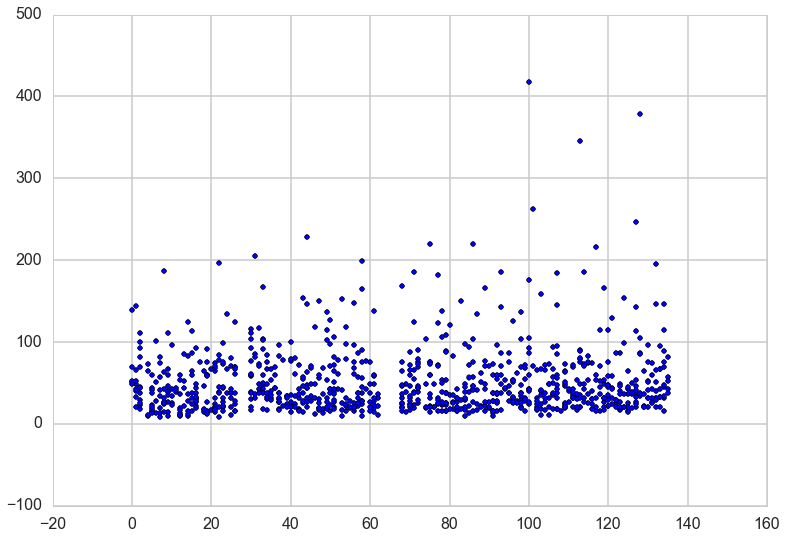

In [9]:
# A little EDA:
plt.scatter(fulldf["daysaway"], fulldf["lowest_price"])

print np.mean(fulldf["lowest_price"][fulldf["daysaway"] < 90])
print np.mean(fulldf["lowest_price"][fulldf["daysaway"] > 90])


In [ ]:
# OUTLINE:
# Short time horizon:
    # logistic for probability that appreciates more than x%
    # regression with y = final price after x days
# In order to extend to further time horizons without data, can regress today's price
    # get ceof. on days away
    # forecast by changing days away

In [10]:
print len(fulldf["avg_price"])
fulldf

1802


,index,listing_count,avg_price,lowest_price_good_deal,lowest_price,highest_price,datetime_local,created_at,address,city,country,extended_address,venueid,venuename,postal_code,venuescore,venuestate,announce_date,short_title,datetime_utc,ticket_score,datetime_tbd,visible_until_utc,id,home_team,away_team,hometeamscore,awayteamscore,dateutc,timeutc,daysaway
0,0,159,251.5,139,139,703,2015-11-27T13:00:00,2015-06-27T00:00:00,100 Legends Way,Boston,US,"Boston, MA 02114",1544,TD Garden,02114,0.85462,MA,2015-06-27T00:00:00,Rangers at Bruins,2015-11-27T18:00:00,0.79923,False,2015-11-27T22:00:00,2666914,Boston Bruins,New York Rangers,0.77818,0.79793,2015-11-27,18:00:00,0
1,1,603,90.0,28,28,606,2015-12-02T19:30:00,2015-06-27T00:00:00,7424 118 Ave NW,Edmonton,Canada,"Edmonton, Canada",163,Rexall Place,T5B 4M9,0.74959,AB,2015-06-27T00:00:00,Bruins at Oilers,2015-12-03T02:30:00,0.75233,False,2015-12-03T06:30:00,2667010,Edmonton Oilers,Boston Bruins,0.65587,0.77818,2015-12-03,02:30:00,6
2,2,532,162.0,32,32,634,2015-12-04T19:00:00,2015-06-27T00:00:00,555 Saddledome Rise SE,Calgary,Canada,"Calgary, Canada",96,Scotiabank Saddledome,T2G 2W1,0.74912,AB,2015-06-27T00:00:00,Bruins at Flames,2015-12-05T02:00:00,0.74101,False,2015-12-05T06:00:00,2666282,Calgary Flames,Boston Bruins,0.65693,0.77818,2015-12-05,02:00:00,8
3,3,744,173.5,67,67,773,2015-12-05T19:00:00,2015-06-27T00:00:00,800 Griffiths Way,Vancouver,Canada,"Vancouver, Canada",2983,Rogers Arena,V6B 6G1,0.76455,BC,2015-06-27T00:00:00,Bruins at Canucks,2015-12-06T03:00:00,0.75653,False,2015-12-06T07:00:00,2666745,Vancouver Canucks,Boston Bruins,0.67661,0.77818,2015-12-06,03:00:00,9
4,4,2312,91.0,44,44,919,2015-12-07T19:00:00,2015-06-27T00:00:00,100 Legends Way,Boston,US,"Boston, MA 02114",1544,TD Garden,02114,0.85463,MA,2015-06-27T00:00:00,Predators at Bruins,2015-12-08T00:00:00,0.79943,False,2015-12-08T04:00:00,2666942,Boston Bruins,Nashville Predators,0.77818,0.65429,2015-12-08,00:00:00,11
5,5,691,215.5,85,85,808,2015-12-09T19:30:00,2015-06-27T00:00:00,1909 Avenue des Canadiens-de-Montreal,Montreal,Canada,"Montreal, Canada",139,Bell Centre,H3C 5L2,0.76007,QC,2015-06-27T00:00:00,Bruins at Canadiens,2015-12-10T00:30:00,0.77162,False,2015-12-10T04:30:00,2667226,Montreal Canadiens,Boston Bruins,0.70075,0.77818,2015-12-10,00:30:00,13
6,6,1985,162.0,86,86,1144,2015-12-12T13:00:00,2015-06-27T00:00:00,100 Legends Way,Boston,US,"Boston, MA 02114",1544,TD Garden,02114,0.85462,MA,2015-06-27T00:00:00,Panthers at Bruins,2015-12-12T18:00:00,0.81072,False,2015-12-12T22:00:00,2666939,Boston Bruins,Florida Panthers,0.77818,0.65476,2015-12-12,18:00:00,15
7,7,2722,100.0,46,46,890,2015-12-14T19:00:00,2015-06-27T00:00:00,100 Legends Way,Boston,US,"Boston, MA 02114",1544,TD Garden,02114,0.85463,MA,2015-06-27T00:00:00,Oilers at Bruins,2015-12-15T00:00:00,0.81092,False,2015-12-15T04:00:00,2666926,Boston Bruins,Edmonton Oilers,0.77818,0.65587,2015-12-15,00:00:00,18
8,8,2401,139.0,67,67,1144,2015-12-16T20:00:00,2015-06-27T00:00:00,100 Legends Way,Boston,US,"Boston, MA 02114",1544,TD Garden,02114,0.85462,MA,2015-06-27T00:00:00,Penguins at Bruins,2015-12-17T01:00:00,0.82236,False,2015-12-17T05:00:00,2666935,Boston Bruins,Pittsburgh Penguins,0.77818,0.70066,2015-12-17,01:00:00,20
9,9,851,170.0,78,78,5880,2015-12-18T19:00:00,2015-06-27T00:00:00,1001 5th Ave,Pittsburgh,US,"Pittsburgh, PA 15219",2265,Consol Energy Center,15219,0.77532,PA,2015-06-27T00:00:00,Bruins at Penguins,2015-12-19T00:00:00,0.76634,False,2015-12-19T04:00:00,2666219,Pittsburgh Penguins,Boston Bruins,0.70066,0.77818,2015-12-19,00:00:00,22
